In [36]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
from collections import defaultdict 

In [37]:
SIZE_IMAGE = 20
NUM_CLASSES = 10

def load_digits_and_labels(big_image):
    """Returns all the digits from the 'big' image and creates the correspnding label for each image """

    digits_img = cv2.imread(big_image, 0)

    #Get all the digit image
    number_rows = digits_img.shape[1] / SIZE_IMAGE
    rows = np.vsplit(digits_img, digits_img.shape[0] /SIZE_IMAGE)

    digits = []
    for row in rows:
        row_cells = np.hsplit(row, number_rows)
        for digit in row_cells:
            digits.append(digit)
    digits = np.array(digits)

    #creating the labels
    labels = np.repeat(np.arange(NUM_CLASSES), len(digits) / NUM_CLASSES)
    return digits, labels 



def get_accuracy(predictions, labels):

    accuracy = (np.squeeze(predictions) == labels).mean()
    return accuracy * 100

def raw_pixels(img):
    return img.flatten()

In [38]:
def deskew(img):
    """pre-processing of the images """

    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5 * SIZE_IMAGE * skew],[0, 1, 0]])
    img = cv2.warpAffine(img, M, (SIZE_IMAGE, SIZE_IMAGE), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

In [39]:
def get_hog():
    """Get HOG-Descriptor"""
    
    hog = cv2.HOGDescriptor((SIZE_IMAGE, SIZE_IMAGE), (8, 8), (4, 4), (8, 8), 9, 1, -1, 0, 0.2, 1, 64, True)
    print("Hog Descriptor Size: {}".format(hog.getDescriptorSize()))
    return hog

In [40]:
#loading all the digits
digits, labels = load_digits_and_labels("images/digits.png")

In [41]:
# Shuffle data
# Constructs a random number generator:
rand = np.random.RandomState(1234)
# Randomly permute the sequence:
shuffle = rand.permutation(len(digits))
digits, labels = digits[shuffle], labels[shuffle]

# HoG feature descriptor:
hog = get_hog()

# Compute the descriptors for all the images.
# In this case, the HoG descriptor is calculated
hog_descriptors = []
for img in digits:
    hog_descriptors.append(hog.compute(deskew(img)))
hog_descriptors = np.squeeze(hog_descriptors)

Hog Descriptor Size: 144


In [42]:

# Split data into training/testing:
split_values = np.arange(0.1, 1, 0.1)

# Create a dictionary to store the accuracy when testing:
results = defaultdict(list)

# Create KNN:
knn = cv2.ml.KNearest_create()

for split_value in split_values:
    # Split the data into training and testing:
    partition = int(split_value * len(hog_descriptors))
    hog_descriptors_train, hog_descriptors_test = np.split(hog_descriptors, [partition])
    labels_train, labels_test = np.split(labels, [partition])

    # Train KNN model
    print('Training KNN model - HOG features')
    knn.train(hog_descriptors_train, cv2.ml.ROW_SAMPLE, labels_train)

    # Store the accuracy when testing:
    for k in np.arange(1, 10):
        ret, result, neighbours, dist = knn.findNearest(hog_descriptors_test, k)
        acc = get_accuracy(result, labels_test)
        print(" {}".format("%.2f" % acc))
        results[int(split_value * 100)].append(acc)

Training KNN model - HOG features
 95.93
 95.62
 96.04
 96.11
 95.98
 95.84
 95.82
 95.73
 95.82
Training KNN model - HOG features
 96.65
 96.70
 97.08
 97.40
 97.05
 97.10
 96.92
 96.92
 96.80
Training KNN model - HOG features
 96.97
 96.89
 97.17
 97.37
 97.34
 97.40
 97.34
 97.34
 97.11
Training KNN model - HOG features
 97.43
 96.97
 97.50
 97.60
 97.73
 97.77
 97.77
 97.60
 97.53
Training KNN model - HOG features
 97.48
 97.32
 97.76
 97.80
 97.72
 97.80
 97.88
 97.68
 97.56
Training KNN model - HOG features
 97.70
 97.55
 97.80
 97.80
 97.75
 97.65
 97.95
 97.90
 97.80
Training KNN model - HOG features
 97.60
 97.47
 97.87
 97.80
 97.93
 97.80
 98.00
 97.93
 98.00
Training KNN model - HOG features
 97.30
 97.60
 97.50
 97.40
 97.40
 97.50
 97.50
 97.50
 97.70
Training KNN model - HOG features
 97.60
 98.60
 98.00
 98.20
 97.60
 98.00
 97.60
 97.80
 98.00


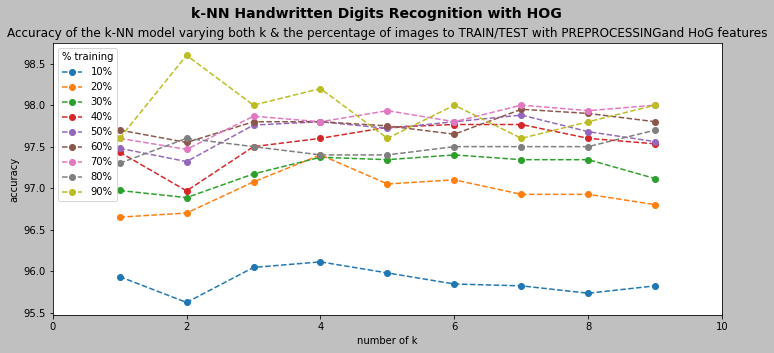

In [43]:

# Show all results using matplotlib capabilities:
# Create the dimensions of the figure and set title:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("k-NN Handwritten Digits Recognition with HOG", fontsize=14, fontweight='bold')
fig.patch.set_facecolor('silver')

ax = plt.subplot(1, 1, 1)
ax.set_xlim(0, 10)
dim = np.arange(1, 10)

for key in results:
    ax.plot(dim, results[key], linestyle='--', marker='o', label=str(key) + "%")

plt.legend(loc='upper left', title="% training")
plt.title('Accuracy of the k-NN model varying both k & the percentage of images to TRAIN/TEST with PREPROCESSING'
          'and HoG features')
plt.xlabel("number of k")
plt.ylabel("accuracy")
plt.show()